In [1]:
def old_HOG(image, cell_size=(8, 8), block_size=(2, 2), bins=9):
    # Chia ảnh thành các ô
    h, w = image.shape
    cells_x = w // cell_size[1]
    cells_y = h // cell_size[0]
    
    # Tính toán histogram cho mỗi ô
    hist = np.zeros((cells_y, cells_x, bins), dtype=np.float32)
    for i in range(cells_y):
        for j in range(cells_x):
            cell = image[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            hist[i, j] = np.histogram(cell, bins=bins, range=(0, 180))[0]

    # Chuẩn hóa histogram cho mỗi khối
    hog_features = []
    for i in range(cells_y - block_size[0] + 1):
        for j in range(cells_x - block_size[1] + 1):
            block = hist[i:i+block_size[0], j:j+block_size[1]].flatten()
            norm_block = block / np.linalg.norm(block) if np.linalg.norm(block) > 0 else block
            hog_features.append(norm_block)

    return np.array(hog_features).flatten()

## Human Detection 

# GetData

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
DataPath = './WiSARD_Multi_Modal_Sample/210417_MtErie_Enterprise_IR_0004'

def GetData(path):
    imgs = []
    labelbox = []
    for file in os.listdir(path):
        if file.split('.')[-1] == 'jpeg':
            imgs.append(os.path.join(path, file))
        else:
            labelbox.append(os.path.join(path, file))
    return imgs, labelbox

In [4]:
imgs, label = GetData(DataPath)

In [5]:
len(imgs), len(label)

(264, 265)

# Drawing boundingbox for data train

In [6]:
def GetImgs(imgs = imgs):
    data = []
    for img in imgs:
        image = cv2.imread(img)
        data.append(image)
    return data

In [7]:
def GetLabelCoord(labelbox):
    labels = []
    for file in labelbox:
        with open(file, 'r') as f:
            lines = f.readlines()
            temp = []
            for line in lines:
                line = line.strip()
                temp.append((line.split(' ')[1:]))
            labels.append(temp)
            temp = []
    return labels

In [8]:
def GetImgsBB(data, label = label):
    data_cp = []
    bboxes = []
    labelsCoord = GetLabelCoord(label)
    for index, image in enumerate(data):
        height, width = image.shape[0], image.shape[1]
        temp = []
        image_copy = image.copy()
        for bbox in labelsCoord[index]:
            if len(bbox) >= 4:
                x_center, y_center, w, h = (float(bbox[0])*width, float(bbox[1])*height, float(bbox[2])*width, float(bbox[3])*height)
                x_min = int(x_center - w/2)
                y_min = int(y_center - h/2)
                x_max = int(x_center + w/2)
                y_max = int(y_center + h/2)
                temp.append((x_min, y_min, x_max, y_max))
                cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=10)
        bboxes.append(temp)
        data_cp.append(image_copy)
    return data_cp, bboxes
                    

        

In [9]:
data = GetImgs()

In [10]:
data__bb, bboxes = GetImgsBB(data)

In [11]:
len(data[0])

512

In [12]:
bboxes[0]

[(202, 165, 229, 201),
 (238, 218, 274, 260),
 (340, 320, 364, 362),
 (472, 150, 510, 180)]

In [13]:
len(data__bb), len(bboxes)

(264, 264)

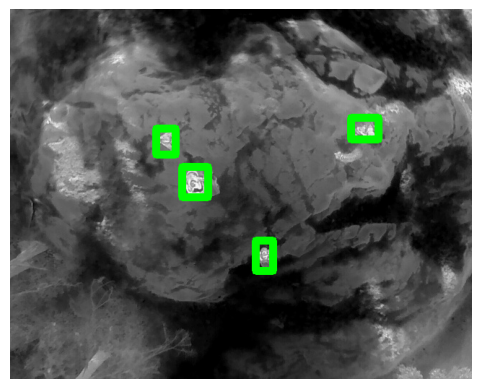

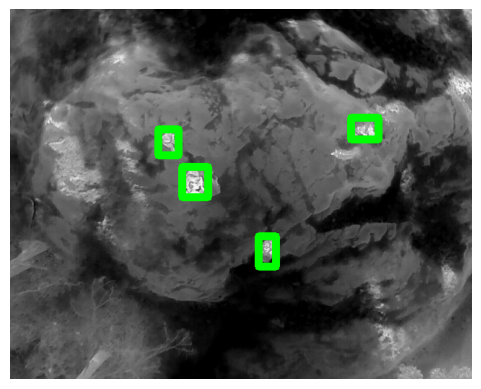

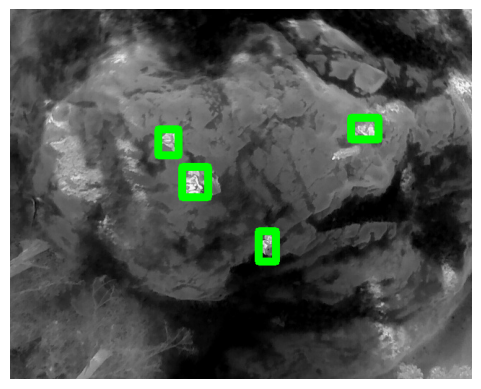

In [14]:
for img in data__bb[:3]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Get the cropped Image for model

In [15]:
def CropImg(imgs, bboxes):
    crops = []
    for index, img in enumerate(imgs):
        for bbox in bboxes[index]:
            x_min, y_min, x_max, y_max = bbox
            crop = img[y_min:y_max, x_min:x_max]
            crops.append(crop)
    return crops

In [16]:

data_crop = CropImg(data, bboxes)

In [17]:
len(data_crop)

1006

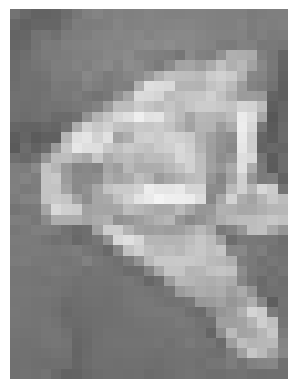

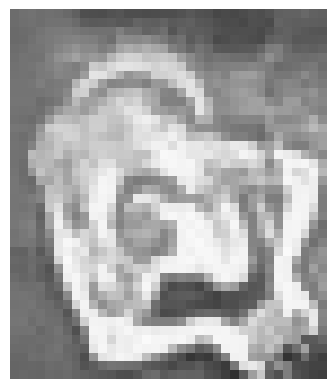

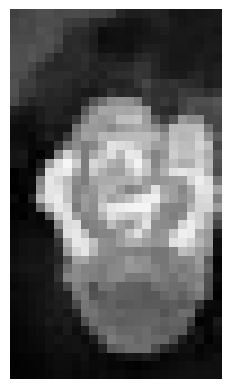

In [18]:
for img in data_crop[:3]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

non-human label

In [19]:
def CheckOverlayBB(crops, bboxes):
    x_min_crop, y_min_crop, x_max_crop, y_max_crop = crops
    for bbox in bboxes:
        x_min_box, y_min_box, x_max_box, y_max_box = bbox
        if (x_max_crop >= x_min_box and x_min_crop <= x_max_box and 
            y_max_crop >= y_min_box and y_min_crop <= y_max_box):
            return False
    return True


In [20]:
def GetImgsBBNonHuman(data, bboxes_crop, num_samples=4, min_size=40, max_size=80):
    random_bbs = []
    for index, img in enumerate(data):
        height, width = img.shape[0], img.shape[1]
        temp = []
        i = 1
        while (i<=num_samples):
            x_min = random.randint(0, width - 40)
            y_min = random.randint(0, height - 40)
            x_max = random.randint(x_min + 40, 
                                   width if (x_min + min_size + max_size) > width else x_min + min_size + max_size)
            y_max = random.randint(y_min + 40, 
                                   height if (y_min + min_size + max_size) > height else y_min + min_size + max_size)
            if CheckOverlayBB((x_min, y_min, x_max, y_max), bboxes_crop[index]):
                temp.append((x_min, y_min, x_max, y_max))
                i+=1
        random_bbs.append(temp)
    return random_bbs

In [21]:
random_bbs_non_human = GetImgsBBNonHuman(data, bboxes)

In [22]:
len(random_bbs_non_human)

264

In [23]:
data_non_human = CropImg(data, random_bbs_non_human)

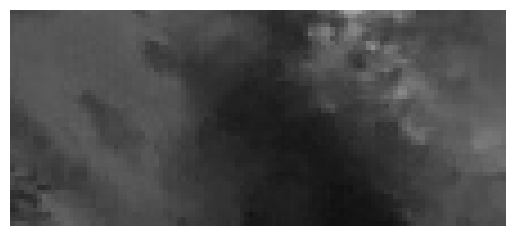

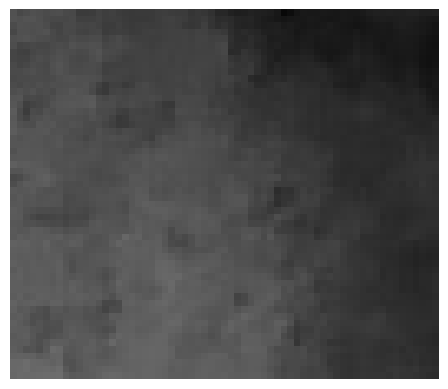

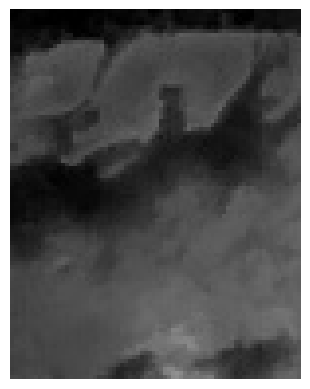

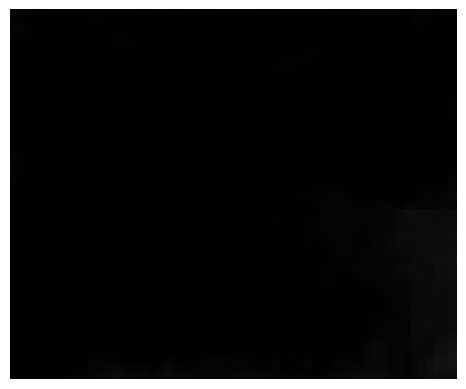

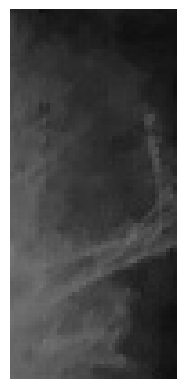

In [24]:
for img in data_non_human[:5]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [25]:
len(data_non_human), len(data_crop)

(1056, 1006)

In [26]:
data_non_human[0].shape, data_crop[0].shape

((48, 110, 3), (36, 27, 3))

In [27]:
label = len(data_non_human)* [1] + len(data_crop)*[0]
label = np.array(label)

data_combined = data_non_human + data_crop
len(data_combined),len(label)

(2062, 2062)

In [28]:
label[1051:1060]

array([1, 1, 1, 1, 1, 0, 0, 0, 0])

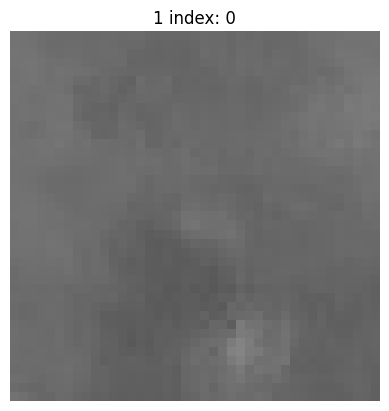

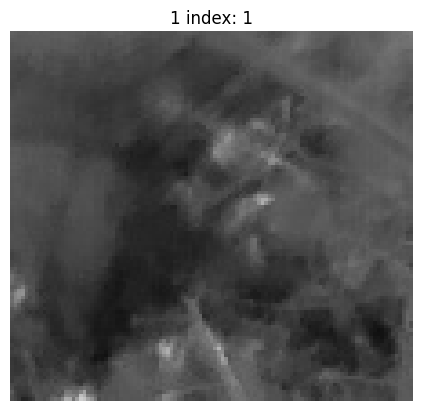

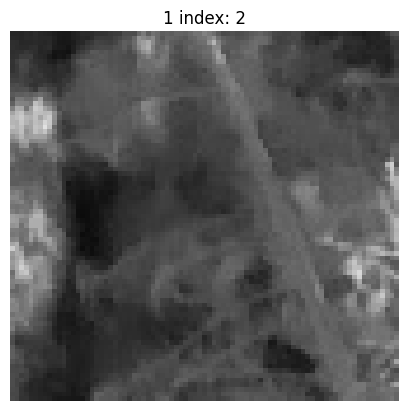

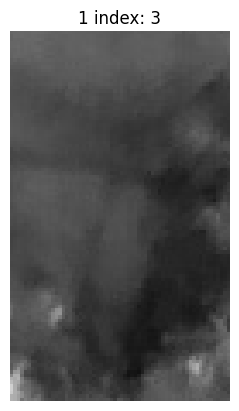

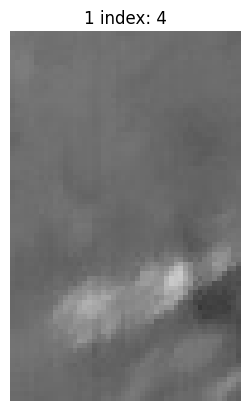

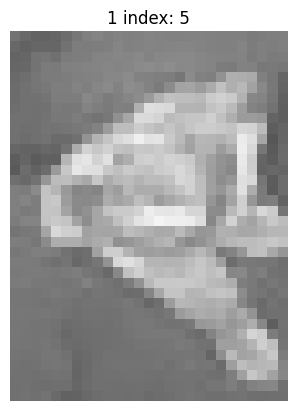

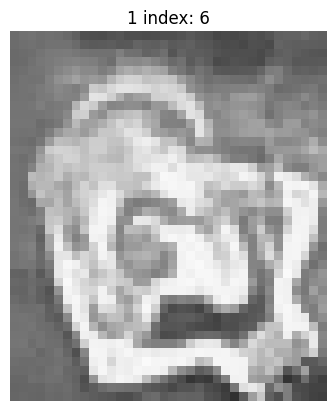

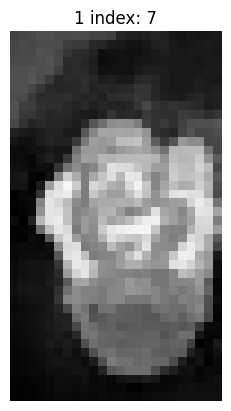

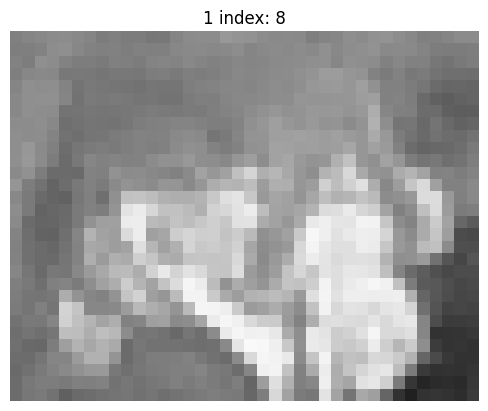

In [29]:

for index, img in enumerate(data_combined[1051:1060]):
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{label[index]} index: {index}')
    plt.show()

In [30]:
for index, img in enumerate(data_combined[-5:5]):
    plt.imshow(img)
    plt.axis(label[index])
    plt.show()

## PREPROCESSING

2. Normalization, Resize, GrayScale

In [31]:
data_combined[0]

array([[[68, 68, 68],
        [69, 69, 69],
        [67, 67, 67],
        ...,
        [79, 79, 79],
        [80, 80, 80],
        [83, 83, 83]],

       [[77, 77, 77],
        [77, 77, 77],
        [74, 74, 74],
        ...,
        [79, 79, 79],
        [80, 80, 80],
        [85, 85, 85]],

       [[78, 78, 78],
        [80, 80, 80],
        [78, 78, 78],
        ...,
        [80, 80, 80],
        [82, 82, 82],
        [86, 86, 86]],

       ...,

       [[51, 51, 51],
        [55, 55, 55],
        [58, 58, 58],
        ...,
        [78, 78, 78],
        [78, 78, 78],
        [80, 80, 80]],

       [[58, 58, 58],
        [58, 58, 58],
        [55, 55, 55],
        ...,
        [75, 75, 75],
        [77, 77, 77],
        [78, 78, 78]],

       [[68, 68, 68],
        [76, 76, 76],
        [77, 77, 77],
        ...,
        [73, 73, 73],
        [76, 76, 76],
        [76, 76, 76]]], dtype=uint8)

In [32]:
def NormalizeData(data_combined):
    data = []
    for img in data_combined:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (64, 64))
        img = img.astype('float32')
        data.append(img)
    return data

In [33]:
data_normalize = NormalizeData(data_combined)

In [34]:
data_normalize[0]

array([[68., 67., 72., ..., 80., 79., 82.],
       [74., 71., 75., ..., 80., 79., 83.],
       [78., 76., 80., ..., 79., 79., 84.],
       ...,
       [56., 56., 60., ..., 79., 76., 78.],
       [63., 63., 62., ..., 77., 74., 77.],
       [71., 77., 67., ..., 75., 73., 76.]], dtype=float32)

## MODEL

1. HOG

In [35]:
def padding(img_pre):
    img_pad = np.zeros((img_pre.shape[0] + 2, img_pre.shape[1] + 2), dtype=np.float32)
    img_pad[1:-1, 1:-1] = img_pre
    img_pad[0,1:-1] = img_pre[1,:] # paddign trên
    img_pad[-1,1:-1] = img_pre[-2,:] # padding dưới
    img_pad[1:-1,0] = img_pre[:,1] # padding trái
    img_pad[1:-1,-1] = img_pre[:,-2] # padding phải
    img_pad[0,0] = img_pad[0,2] # padding trên trái
    img_pad[0,-1] = img_pad[0,-3] # padding trên phải
    img_pad[-1,0] = img_pad[-1,2] # padding dưới trái
    img_pad[-1,-1] = img_pad[-1,-3] # padding dưới phải
    return img_pad

In [36]:
def Gradient(img_pre):
    h, w = img_pre.shape
    img_pad = padding(img_pre)
    gradient_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    gradient_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    img_gradient_direction = np.zeros((h, w), dtype=np.float32)
    img_gradient_magnitude = np.zeros((h, w), dtype=np.float32)
    img_cp = np.zeros((3, 3), dtype=np.float32)
    for i in range(1,h+1):
        for j in range(1,w+1):
            img_cp = img_pad[i-1:i+2, j-1:j+2] # Th binh thuong
            gradient_x_value = np.sum(img_cp * gradient_x)
            gradient_y_value = np.sum(img_cp * gradient_y)
            img_gradient_direction[i-1, j-1] = abs(np.arctan2(gradient_y_value, gradient_x_value) * 180 / np.pi)
            img_gradient_magnitude[i-1, j-1] = np.sqrt(gradient_x_value**2 + gradient_y_value**2)
            
    return img_gradient_direction, img_gradient_magnitude

In [37]:
data_gradient_direction, data_gradient_magnitude = Gradient(data_normalize[0])
data_gradient_direction.shape, data_gradient_magnitude.shape

((64, 64), (64, 64))

In [38]:
def Histogram(img_gradient_direction, img_gradient_magnitude, bins=9):
    h, w = img_gradient_direction.shape
    bin_width = 180 / bins
    histogram = np.zeros((bins), dtype=np.float32)
    for i in range(h):
        for j in range(w):
            index = np.floor(img_gradient_direction[i, j] / 180 * bins).astype(int)
            left_affect = (bin_width*(index+1)-img_gradient_direction[i, j]) / bin_width
            right_affect = (img_gradient_direction[i, j]-bin_width*index) / bin_width
            histogram[index%bins] += img_gradient_magnitude[i, j] * left_affect
            histogram[(index+1)%bins] += img_gradient_magnitude[i, j] * right_affect
    return histogram

In [39]:
def HOG(data_direction, data_magnitude, cell_size=(8, 8), block_size=(2, 2), bins=9):
    h, w = data_direction.shape
    cells_x = w // cell_size[1]
    cells_y = h // cell_size[0]
    
    hist = np.zeros((cells_y, cells_x, bins), dtype=np.float32)
    for i in range(cells_y):
        for j in range(cells_x):
            cell_dir = data_direction[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            cell_mag = data_magnitude[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            hist[i, j] = Histogram(cell_dir, cell_mag, bins=bins)

    hog_features = []
    for i in range(cells_y - block_size[0] + 1):
        for j in range(cells_x - block_size[1] + 1):
            block = hist[i:i+block_size[0], j:j+block_size[1]].flatten()
            norm_block = block / np.linalg.norm(block) if np.linalg.norm(block) > 0 else block
            hog_features.append(norm_block)

    return np.array(hog_features).flatten()

In [40]:
hog_result = HOG(data_gradient_direction, data_gradient_magnitude)
hog_result.shape

(1764,)

In [41]:
def DataHOG(data_normalize):
    hog_features = []
    for img in data_normalize:
        img_gradient_direction, img_gradient_magnitude = Gradient(img)
        hog_feature = HOG(img_gradient_direction, img_gradient_magnitude)
        hog_features.append(hog_feature)
    return np.array(hog_features)

In [42]:
data_HOG = DataHOG(data_normalize)
data_HOG.shape, label.shape

((2062, 1764), (2062,))

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

model_detect_human = SVC(kernel='linear', C=10, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(data_HOG, label, test_size=0.2, random_state=42)
model_detect_human.fit(x_train, y_train)
y_pred = model_detect_human.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       204
           1       0.99      0.99      0.99       209

    accuracy                           0.99       413
   macro avg       0.99      0.99      0.99       413
weighted avg       0.99      0.99      0.99       413



In [44]:
x_test.shape

(413, 1764)

# DETECT

Sliding Window

In [53]:
def NormalizeImage(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (64, 64))
    image = image.astype('float32')
    return image

In [54]:
def SlidingWindow(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size[1]):
        for x in range(0, image.shape[1] - window_size[0], step_size[0]):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [55]:
def DetectHuman(image, model):
    image = NormalizeImage(image)
    img_direction, img_magnitude = Gradient(image)
    hog_features = HOG(img_direction, img_magnitude)
    hog_features = hog_features.reshape(1, -1)
    prediction = model.predict(hog_features)
    return prediction

In [56]:
def BoundingBox(image, model, step_size=(20, 20), window_size=(40, 40)):
    bboxes = []
    for (x,y,image) in SlidingWindow(image, step_size, window_size):
        if DetectHuman(image, model) == 0:
            print(x, y, x + window_size[0], y + window_size[1])
            bboxes.append((x, y, x + window_size[0], y + window_size[1])) #(x_min, y_min, x_max, y_max)
    return bboxes

In [57]:
def DrawBBox(image, bboxes):
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
    return image

280 0 320 40
340 0 380 40
340 20 380 60
80 80 120 120
280 80 320 120
320 80 360 120
460 80 500 120
220 100 260 140
460 100 500 140
220 120 260 160
460 120 500 160
200 140 240 180
260 240 300 280
320 260 360 300
160 300 200 340
440 300 480 340
420 320 460 360
440 320 480 360
480 320 520 360
380 340 420 380
400 340 440 380
420 340 460 380
440 340 480 380
220 360 260 400
380 360 420 400
60 380 100 420
560 380 600 420
420 420 460 460


(-0.5, 639.5, 511.5, -0.5)

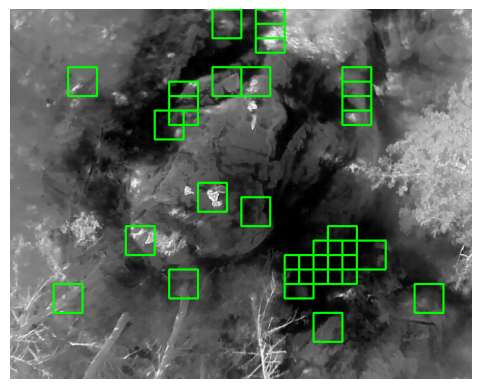

In [58]:
test = cv2.imread(imgs[15])
bboxes = BoundingBox(test, model_detect_human)
test_with_bboxes = DrawBBox(test, bboxes)
plt.imshow(test_with_bboxes)
plt.axis('off')